In [1]:
import tensorflow as tf
from tensorflow.python.keras import layers, losses
import matplotlib.pyplot as plt
import os

# Data location:

In [2]:
data_folder = "formula-name"

dataset_directory = os.path.join(os.path.dirname("data"), "data", data_folder)
train_directory = os.path.join(dataset_directory, "train")
test_directory = os.path.join(dataset_directory, "test")

print("In data:", os.listdir(dataset_directory))
print("In train:", os.listdir(train_directory))
print("In test:", os.listdir(test_directory))

In data: ['inorganic-formulas.txt', 'inorganic-names.txt', 'organic-formulas.txt', 'organic-names.txt', 'test', 'train']
In train: ['inorganic-formula', 'inorganic-formulas-90%.txt', 'inorganic-name', 'inorganic-names-90%.txt', 'organic-formula', 'organic-formulas-90%.txt', 'organic-name', 'organic-names-90%.txt']
In test: ['inorganic-formula', 'inorganic-formulas-10%.txt', 'inorganic-name', 'inorganic-names-10%.txt', 'organic-formula', 'organic-formulas-10%.txt', 'organic-name', 'organic-names-10%.txt']


### Sample file:

In [35]:
sample_file = os.path.join(train_directory, "inorganic-formula", "aa.txt")

print("Sample file:", open(sample_file).read())

Sample file: 



# Data collection:

In [4]:
seed = 32 # Random seed for data shuffling and transformations
validation_split = 0.2 # Proportion of train data used to validate the model

In [5]:
raw_train_data_source = tf.keras.utils.text_dataset_from_directory(
    train_directory,
    subset = "training",
    seed = seed,
    validation_split = validation_split,
)

Found 18229 files belonging to 4 classes.
Using 14584 files for training.


In [6]:
raw_validation_data_source = tf.keras.utils.text_dataset_from_directory(
    train_directory,
    subset = "validation",
    seed = seed,
    validation_split = validation_split,
)

Found 18229 files belonging to 4 classes.
Using 3645 files for validation.


In [7]:
raw_test_data_source = tf.keras.utils.text_dataset_from_directory(
    test_directory,
)

Found 3012 files belonging to 4 classes.


# Data pre-processing:

In [8]:
def data_standardization(input_data): # CH3-CH=CH-CH(NO2)Br
    input_data = tf.strings.lower(input_data) # ch3-ch=ch-ch(no2)br
    input_data = tf.strings.regex_replace(input_data, "[^a-zà-ú]", ' ') # ch  ch ch ch no  br
    return tf.strings.regex_replace(input_data, "\s+", ' ') # ch ch ch ch no br

In [9]:
max_features = 2048 # Sets a boundary for len(vectorize_layer.get_vocabulary())

In [10]:
sequence_length = 16 # Vectorized string's dimension

vectorize_layer = tf.keras.layers.TextVectorization(
    output_mode = "int",
    max_tokens = max_features,
    standardize = data_standardization,
    output_sequence_length = sequence_length
)

In [11]:
# Makes a text-only dataset (without labels), then calls adapt
train_text = raw_train_data_source.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [13]:
# Retrieves a batch of 32 reviews and labels from the dataset
text_batch, label_batch = next(iter(raw_train_data_source))
first_review, first_label = text_batch[0], label_batch[0]

print("Review:", first_review)
print("Label:", raw_train_data_source.class_names[first_label])
print("Vectorized review:", vectorize_text(first_review, first_label))

Review: tf.Tensor(b'CH2Cl-CH2-CH2-CH=CH2\r\n', shape=(), dtype=string)
Label: organic-formula
Vectorized review: (<tf.Tensor: shape=(1, 16), dtype=int64, numpy=
array([[ 2, 17,  2,  2,  2,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
      dtype=int64)>, <tf.Tensor: shape=(), dtype=int32, numpy=2>)


In [14]:
print("Vocabulary size:", len(vectorize_layer.get_vocabulary()))

Vocabulary size: 2048


In [15]:
print("Vocabulary:", sorted(vectorize_layer.get_vocabulary(), key = len))

Vocabulary: ['', 'c', 'o', 'i', 'f', 'v', 's', 'h', 'p', 'n', 'u', 'k', 'b', 'w', 'y', 'ch', 'no', 'en', 'ol', 'oh', 'in', 'cl', 'nh', 'br', 'de', 'cf', 'ci', 'co', 'io', 'so', 'cn', 'po', 'ii', 'iv', 'ni', 'cr', 'pb', 'fe', 'bi', 'au', 'cu', 'pt', 'sn', 'mn', 'ti', 'vi', 'hg', 'si', 'se', 'te', 'sb', 'mo', 'as', 'bo', 'os', 'al', 'ta', 'nb', 'pd', 'ag', 'li', 'ga', 'tl', 'ca', 'na', 'zr', 'zn', 'mg', 'cs', 'cd', 'ba', 'sr', 'rb', 'sc', 'ra', 'ir', 'ru', 're', 'eu', 'la', 'be', 'sm', 'rh', 'fr', 'ce', 'wo', 'tc', 'pr', 'am', 'th', 'ho', 'hf', 'tm', 'pu', 'lu', 'ac', 'np', 'yb', 'vo', 'dy', 'cm', 'bk', 'tb', 'uf', 'pa', 'gd', 'pm', 'nd', 'if', 'vh', 'vf', 'us', 'sf', 'ph', 'nf', 'kh', 'hs', 'ge', 'es', 'yn', 'yi', 'yh', 'yf', 'ws', 'wp', 'wn', 'wh', 'wf', 'wc', 'vs', 'vp', 'vn', 'vc', 'ui', 'uh', 'ts', 'rn', 'rf', 'pn', 'pi', 'pf', 'og', 'ne', 'mt', 'md', 'kr', 'ki', 'kf', 'hi', 'ino', 'ona', 'ccl', 'cbr', 'chf', 'chi', 'eno', 'clo', 'cho', 'bro', 'teo', 'iii', 'seo', 'aso', 'but', 'cro

In [16]:
train_data_source = raw_train_data_source.map(vectorize_text)
validation_data_source = raw_validation_data_source.map(vectorize_text)
test_data_source = raw_test_data_source.map(vectorize_text)

In [17]:
AUTOTUNE = tf.data.AUTOTUNE # ??

train_data_source = train_data_source.cache().prefetch(buffer_size = AUTOTUNE)
validation_data_source = validation_data_source.cache().prefetch(buffer_size = AUTOTUNE)
test_data_source = test_data_source.cache().prefetch(buffer_size = AUTOTUNE)

# Model creation:

In [18]:
embedding_dim = 16 # ??

In [19]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.Dense(256, activation = "relu"),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1),
])

### Loss function and optimizer:

In [20]:
model.compile(
    optimizer = "adam",
    metrics = tf.metrics.BinaryAccuracy(threshold = 0.0),
    loss = losses.BinaryCrossentropy(from_logits = True),
)

### Training:

In [28]:
epochs = 50

history = model.fit(
    epochs = epochs,
    x = train_data_source,
    validation_data = validation_data_source,
)

Epoch 1/50
456/456 [==============================] - 2s 3ms/step - loss: -211752.5156 - binary_accuracy: 0.0589 - val_loss: -249177.5938 - val_binary_accuracy: 0.0689
Epoch 2/50
456/456 [==============================] - 1s 3ms/step - loss: -324801.6562 - binary_accuracy: 0.0589 - val_loss: -368826.0625 - val_binary_accuracy: 0.0689
Epoch 3/50
456/456 [==============================] - 1s 3ms/step - loss: -465252.8750 - binary_accuracy: 0.0589 - val_loss: -515512.8125 - val_binary_accuracy: 0.0689
Epoch 4/50
456/456 [==============================] - 1s 3ms/step - loss: -635938.2500 - binary_accuracy: 0.0589 - val_loss: -690802.8750 - val_binary_accuracy: 0.0689
Epoch 5/50
456/456 [==============================] - 1s 3ms/step - loss: -836338.7500 - binary_accuracy: 0.0589 - val_loss: -895694.6875 - val_binary_accuracy: 0.0689
Epoch 6/50
456/456 [==============================] - 1s 3ms/step - loss: -1069152.0000 - binary_accuracy: 0.0589 - val_loss: -1131565.6250 - val_binary_accurac

### Compiling:

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation("sigmoid")
])

export_model.compile(
    optimizer = "adam", 
    metrics = ["accuracy"],
    loss = losses.BinaryCrossentropy(from_logits = False), 
)

# Model evaluation:

### Using test data:

In [30]:
loss, accuracy = model.evaluate(test_data_source)

print("Test loss:", loss)
print("Test accuracy:", accuracy)

95/95 [==============================] - 0s 1ms/step - loss: -44983788.0000 - binary_accuracy: 0.3685
Test loss: -44983788.0
Test accuracy: 0.368525892496109


### Using raw test data:

In [31]:
loss, accuracy = export_model.evaluate(raw_test_data_source)

print("Raw test loss:", loss)
print("Raw test accuracy:", accuracy)

95/95 [==============================] - 1s 8ms/step - loss: -44983796.0000 - accuracy: 0.3685
Raw test loss: -44983796.0
Raw test accuracy: 0.368525892496109


### Accuracy graph:

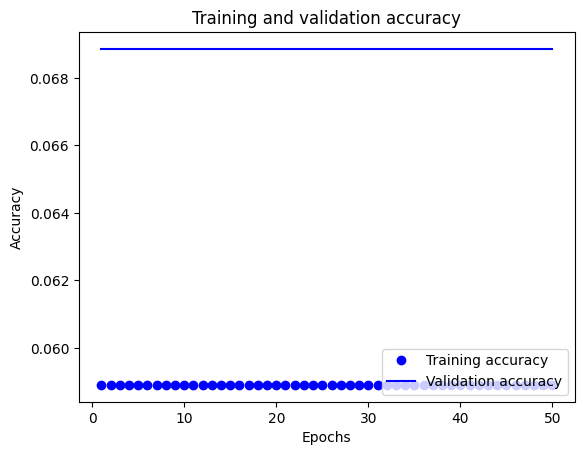

In [32]:
history_dict = history.history
history_dict.keys()

accuracy = history_dict["binary_accuracy"]
validation_accuracy = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
validation_loss = history_dict["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy") # Blue dots
plt.plot(epochs, validation_accuracy, "b", label = "Validation accuracy") # Blue line
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

### Loss graph:

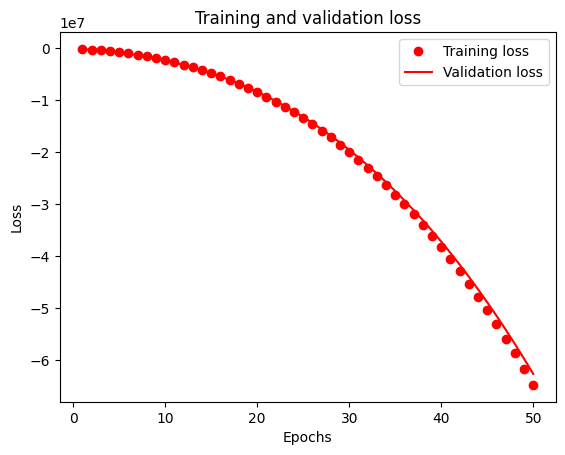

In [33]:
plt.plot(epochs, loss, "ro", label = "Training loss") # Red dots
plt.plot(epochs, validation_loss, "r", label = "Validation loss") # Red line
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Model predictions:

In [34]:
examples = [
    "H3C-CH2",
    "ChCh",
    "CH3-CO-O-CH2-CH3",
    "CH3-CH2-O-CH2-CH3",
    "CH3-CH2-CH=CH-COOH",
    "ch3chch2ch(ch2ch2ch3)cooh",
    "ch3(Ch3)Chch2Ch(Ch3)Ch2Ch(Ch2Ch2Ch3)Ch3",
    "benceno",
    "2-cloropentanato",
    "di 2-cloropentanil éter",
    "2-bromo-2-cloropropano",
    "metanoato de isopropilo",
    "orto-difenilciclohexano",
    "2-bromo-2-cloropropil yododecil éter",
    "3-cloro-2-fluoro-hexa-1,3-dien-5-in-1-ona",
    "4-amino-2,6,6-tricloro-7,7-difluoro-89-metil-3-nitro-1,1-diyodononaconta-1,3-dien-5-ona",
]

for example in examples:
    percentage = export_model.predict([example])[0][0] * 100
    print("Formula" if percentage < 50 else "Name", "(" + "%.2f" % percentage + " %):", example)

1/1 [==============================] - 0s 177ms/step
Name (100.00 %): H3C-CH2
1/1 [==============================] - 0s 49ms/step
Name (100.00 %): ChCh
1/1 [==============================] - 0s 49ms/step
Name (100.00 %): CH3-CO-O-CH2-CH3
1/1 [==============================] - 0s 52ms/step
Name (100.00 %): CH3-CH2-O-CH2-CH3
1/1 [==============================] - 0s 50ms/step
Name (100.00 %): CH3-CH2-CH=CH-COOH
1/1 [==============================] - 0s 50ms/step
Name (100.00 %): ch3chch2ch(ch2ch2ch3)cooh
1/1 [==============================] - 0s 55ms/step
Name (100.00 %): ch3(Ch3)Chch2Ch(Ch3)Ch2Ch(Ch2Ch2Ch3)Ch3
1/1 [==============================] - 0s 51ms/step
Name (100.00 %): benceno
1/1 [==============================] - 0s 56ms/step
Name (100.00 %): 2-cloropentanato
1/1 [==============================] - 0s 52ms/step
Name (100.00 %): di 2-cloropentanil éter
1/1 [==============================] - 0s 47ms/step
Name (100.00 %): 2-bromo-2-cloropropano
1/1 [==============================